<a href="https://colab.research.google.com/github/asmaaabdelsattar/instant-training/blob/main/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

In [15]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
base_dir = '/content/drive/MyDrive/braintumor'

train_dir = os.path.join(base_dir, 'brain_tumor_train')
test_dir  = os.path.join(base_dir, 'brain_tumor_test')

In [13]:
print("Train dir:", train_dir)
print("Test dir:", test_dir)
print("Train yes count:", len(os.listdir(os.path.join(train_dir, 'yes'))))
print("Train no count:", len(os.listdir(os.path.join(train_dir, 'no'))))
print("Test yes count:", len(os.listdir(os.path.join(test_dir, 'yes'))))
print("Test no count:", len(os.listdir(os.path.join(test_dir, 'no'))))


Train dir: /content/drive/MyDrive/braintumor/brain_tumor_train
Test dir: /content/drive/MyDrive/braintumor/brain_tumor_test
Train yes count: 155
Train no count: 98
Test yes count: 155
Test no count: 98


In [18]:
# ===  Image Data Generators ===
batch_size = 16
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Split training set into train/validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=seed
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [19]:
# ===  Model Architecture ===
img_shape = (img_size[0], img_size[1], 3)

model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=img_shape),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary output
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,544,193 (200.44 MB)

 Trainable params: 52,543,297 (200.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [20]:
# ===  Callbacks ===
checkpoint_path = '/content/best_brain_tumor_model.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

In [22]:
# ===  Train Model ===
epochs = 12
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5928 - loss: 5.8417 
Epoch 1: val_loss did not improve from 1.35605
13/13 ━━━━━━━━━━━━━━━━━━━━ 268s 21s/step - accuracy: 0.5958 - loss: 5.8095 - val_accuracy: 0.6200 - val_loss: 3.2370 - learning_rate: 2.5000e-04
Epoch 2/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6405 - loss: 3.7013 
Epoch 2: val_loss did not improve from 1.35605
13/13 ━━━━━━━━━━━━━━━━━━━━ 259s 20s/step - accuracy: 0.6412 - loss: 3.7214 - val_accuracy: 0.6200 - val_loss: 4.7274 - learning_rate: 2.5000e-04
Epoch 3/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7038 - loss: 3.4352 
Epoch 3: val_loss did not improve from 1.35605
13/13 ━━━━━━━━━━━━━━━━━━━━ 260s 20s/step - accuracy: 0.7021 - loss: 3.4446 - val_accuracy: 0.6200 - val_loss: 5.0209 - learning_rate: 2.5000e-04
Epoch 4/12
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.6159 - loss: 2.8301 
Epoch 4: val_loss did not improve from 1.35605

Epoch 4: ReduceLROnPlateau reducing 

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# === 3. Transfer Learning Model ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers (only fine-tune top layers)
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [24]:
epochs = 15

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6101 - loss: 0.6956 
Epoch 1: val_loss improved from 1.35605 to 0.61627, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 189s 14s/step - accuracy: 0.6077 - loss: 0.6968 - val_accuracy: 0.7600 - val_loss: 0.6163 - learning_rate: 1.0000e-04
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6218 - loss: 0.6085 
Epoch 2: val_loss improved from 0.61627 to 0.49432, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 194s 15s/step - accuracy: 0.6246 - loss: 0.6077 - val_accuracy: 0.7800 - val_loss: 0.4943 - learning_rate: 1.0000e-04
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7369 - loss: 0.5063 
Epoch 3: val_loss improved from 0.49432 to 0.46650, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.7406 - loss: 0.5035 - val_accuracy: 0.7400 - val_loss: 0.4665 - learning_rate: 1.0000e-04
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8636 - loss: 0.3644 
Epoch 4: val_loss did not improve from 0.46650
13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.8614 - loss: 0.3669 - val_accuracy: 0.7600 - val_loss: 0.5286 - learning_rate: 1.0000e-04
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8167 - loss: 0.4396 
Epoch 5: val_loss improved from 0.46650 to 0.39915, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 195s 15s/step - accuracy: 0.8172 - loss: 0.4368 - val_accuracy: 0.7800 - val_loss: 0.3991 - learning_rate: 1.0000e-04
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8423 - loss: 0.3721 
Epoch 6: val_loss improved from 0.39915 to 0.38936, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.8440 - loss: 0.3696 - val_accuracy: 0.8400 - val_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8695 - loss: 0.3084 
Epoch 7: val_loss improved from 0.38936 to 0.26621, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.8704 - loss: 0.3076 - val_accuracy: 0.8600 - val_loss: 0.2662 - learning_rate: 1.0000e-04
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9284 - loss: 0.2176 
Epoch 8: val_loss did not improve from 0.26621
13/13 ━━━━━━━━━━━━━━━━━━━━ 186s 14s/step - accuracy: 0.9261 - loss: 0.2212 - val_accuracy: 0.8200 - val_loss: 0.4591 - learning_rate: 1.0000e-04
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8796 - loss: 0.3543 
Epoch 9: val_loss improved from 0.26621 to 0.26056, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.8812 - loss: 0.3462 - val_accuracy: 0.8600 - val_loss: 0.2606 - learning_rate: 1.0000e-04
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9580 - loss: 0.1404 
Epoch 10: val_loss improved from 0.26056 to 0.22189, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.9578 - loss: 0.1409 - val_accuracy: 0.9000 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9724 - loss: 0.1144 
Epoch 11: val_loss did not improve from 0.22189
13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.9716 - loss: 0.1154 - val_accuracy: 0.8600 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 12/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9348 - loss: 0.1453 
Epoch 12: val_loss improved from 0.22189 to 0.17220, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 186s 14s/step - accuracy: 0.9359 - loss: 0.1432 - val_accuracy: 0.9400 - val_loss: 0.1722 - learning_rate: 1.0000e-04
Epoch 13/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9806 - loss: 0.0560 
Epoch 13: val_loss improved from 0.17220 to 0.14216, saving model to /content/best_brain_tumor_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 190s 15s/step - accuracy: 0.9799 - loss: 0.0575 - val_accuracy: 0.9200 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 14/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9908 - loss: 0.0388 
Epoch 14: val_loss did not improve from 0.14216
13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.9901 - loss: 0.0405 - val_accuracy: 0.9200 - val_loss: 0.1765 - learning_rate: 1.0000e-04
Epoch 15/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9467 - loss: 0.1055 
Epoch 15: val_loss did not improve from 0.14216
13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 14s/step - accuracy: 0.9459 - loss: 0.1063 - val_accuracy: 0.9000 - val_loss: 0.2670 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 13.


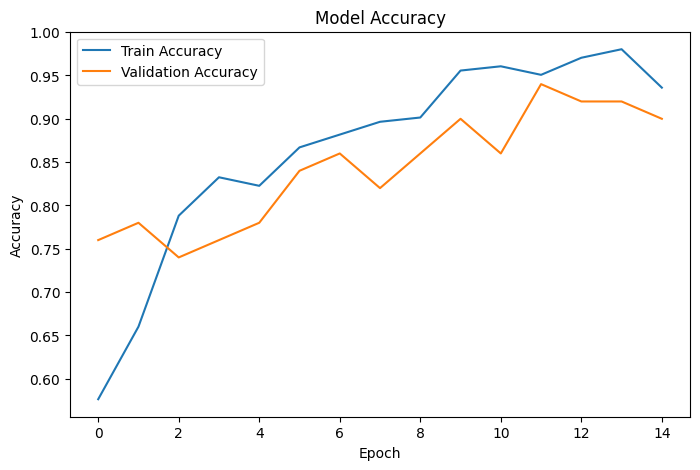

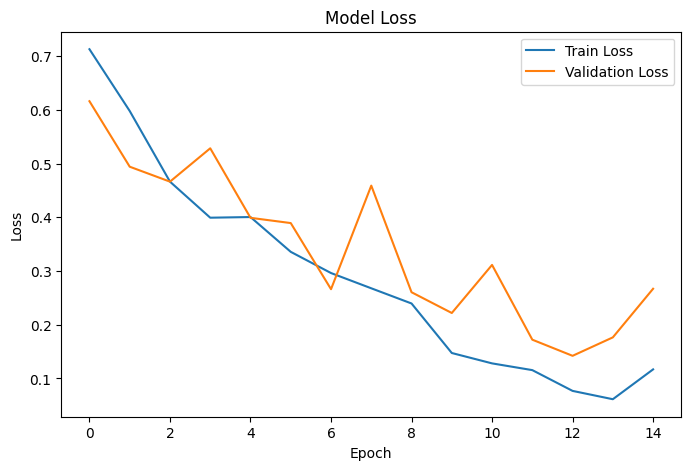

In [25]:
# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 164s 10s/step - accuracy: 0.9752 - loss: 0.0762
Test Accuracy: 0.9802
Test Loss: 0.0654


16/16 ━━━━━━━━━━━━━━━━━━━━ 166s 10s/step


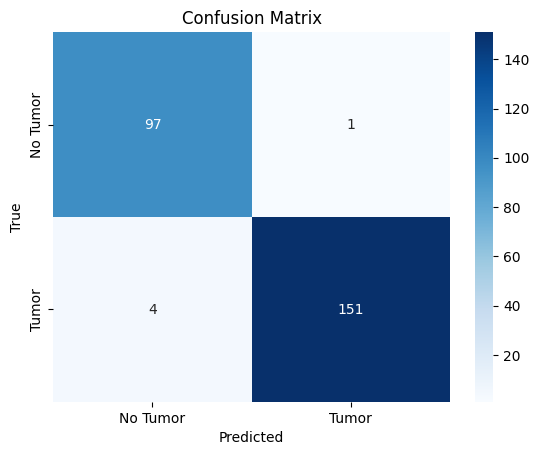

              precision    recall  f1-score   support

    No Tumor       0.96      0.99      0.97        98
       Tumor       0.99      0.97      0.98       155

    accuracy                           0.98       253
   macro avg       0.98      0.98      0.98       253
weighted avg       0.98      0.98      0.98       253



In [27]:
test_generator.reset()
pred_probs = model.predict(test_generator)
preds = (pred_probs > 0.5).astype(int).reshape(-1)
true = test_generator.classes

cm = confusion_matrix(true, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true, preds, target_names=['No Tumor', 'Tumor']))


In [28]:
model.save('/content/drive/MyDrive/braintumor/brain_tumor_vgg16_final.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


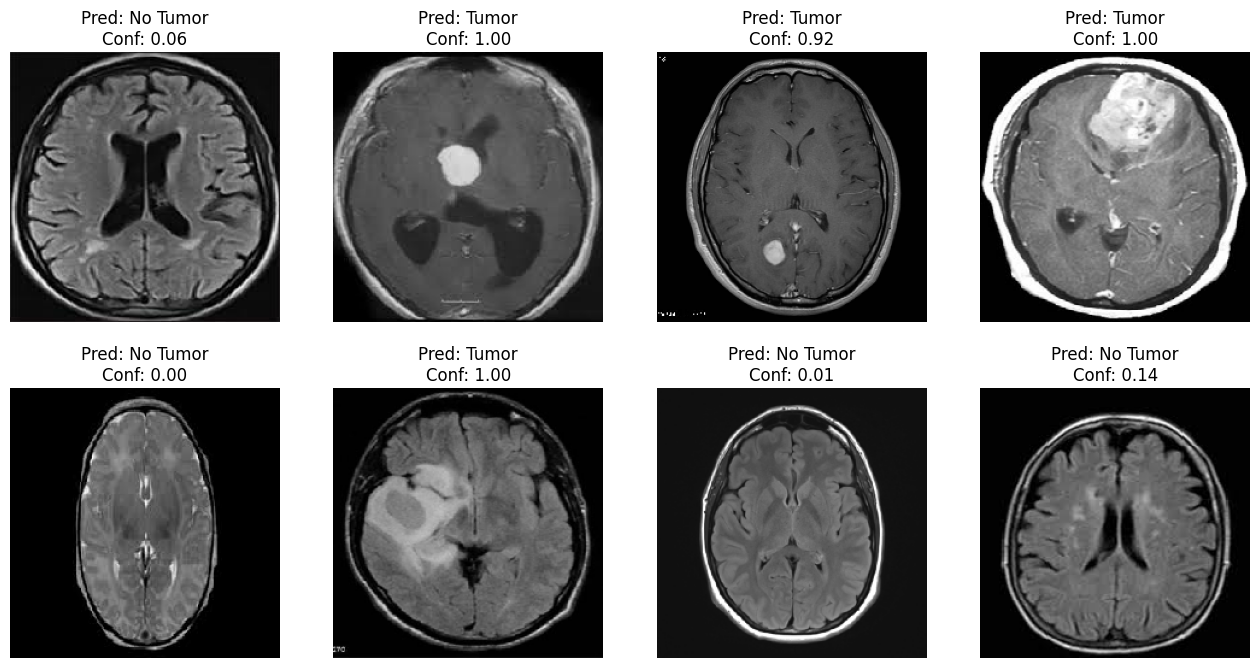

In [29]:
import random
from tensorflow.keras.preprocessing import image

# Random sample
sample_indices = random.sample(range(len(test_generator.filenames)), 8)
plt.figure(figsize=(16, 8))

for i, idx in enumerate(sample_indices):
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))[0][0]
    label = "Tumor" if pred > 0.5 else "No Tumor"

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {label}\nConf: {pred:.2f}")
    plt.axis("off")

plt.show()